# 와인 품질 예측하기


![](https://labelyourdata.com/img/article-illustrations/ml_essential_tool.jpg)

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Input
from keras.backend import clear_session
from keras.optimizers import Adam

* 함수 만들기

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

In [3]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/winequality-white.csv"
data = pd.read_csv(path)
data['quality'] = np.where(data['quality'] == 3, 4, np.where(data['quality'] == 9, 8, data['quality']))
data['quality'] = data['quality'] - 4
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,2
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,2
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,2
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2


* 범주가 5개 입니다.
    * 0 - 최하  ~  4 - 최상

In [4]:
data['quality'].value_counts()

,count
quality,
2,2198
1,1457
3,880
0,183
4,180


## 2.데이터 준비

### (1) 데이터 준비
* y에 대한 전처리 : 위에서 이미 0 ~ 4로 범주를 맞췄습니다.
* x, y 나누기

In [5]:
target = 'quality'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (2) 데이터 분할

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size= .3, random_state = 20)

### (3) 스케일링

In [7]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## 3.모델링

최소 3개 이상의 모델을 생성하고 성능을 비교하시오.

In [9]:
n = x_train.shape[1]
n

11

### (1) 모델1

In [10]:
# 메모리 정리
clear_session()

# 모델 생성
model = Sequential(
    [Input(shape = (n,)),
     Dense(8,activation='relu'),
     Dense(5,activation='softmax') # 다중분류에서 output layer는 softmax 이다 ,
     # 그리고 target 범주 수 만큼 output  5가지 등급 중 하나 예측
     ]
)

# 모델요약
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 0,1,2 정수 인코디시 loss function은 sparse_categorical_crossentropy 사용한다
model.compile(optimizer=Adam(learning_rate=0.01), loss= 'sparse_categorical_crossentropy')

# 0,1,2,3 정수 라벨링인 경우 loss function 은 sparse_categorical_crossentropy
history = model.fit(x_train, y_train, epochs = 100,validation_split=0.2, verbose= False).history


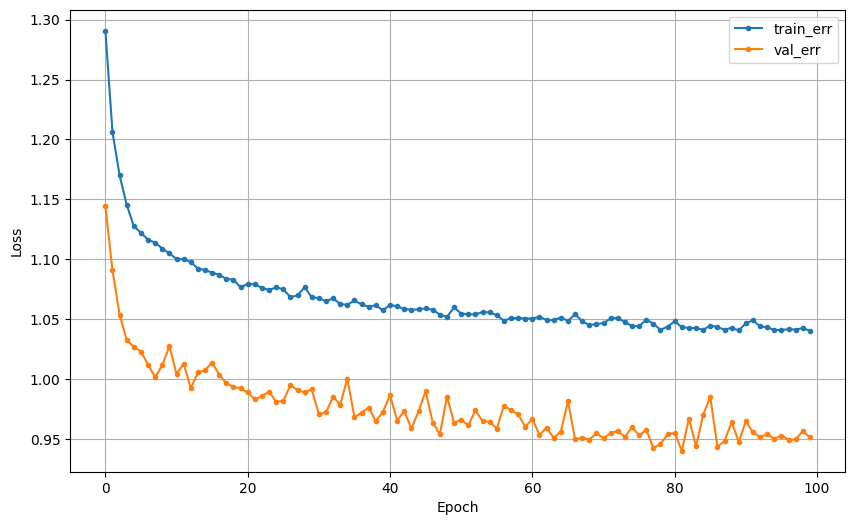

In [12]:
# 학습결과 그래프
dl_history_plot(history)

In [13]:
# 예측 + 평가
pred = model.predict(x_val)
# softmax는 결과들 중에서 가장 유력한 것을 선택해야 함
pred = pred.argmax(axis=1) # target범주들 중에서 가장 유력한 것을 선택

print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[  5  31  21   3   1]
 [  3 252 169  12   2]
 [  0 131 452  77   0]
 [  0   5 155  90   0]
 [  0   0  29  32   0]]
              precision    recall  f1-score   support

           0       0.62      0.08      0.14        61
           1       0.60      0.58      0.59       438
           2       0.55      0.68      0.61       660
           3       0.42      0.36      0.39       250
           4       0.00      0.00      0.00        61

    accuracy                           0.54      1470
   macro avg       0.44      0.34      0.35      1470
weighted avg       0.52      0.54      0.52      1470



### (2) 모델2

In [ ]:
# 신경망 모델 복잡하게 해보자 : 11 > 22 > 5

In [15]:
# 메모리 정리
clear_session()

# 모델 생성
model = Sequential(
    [Input(shape = (n,)),
     Dense(11,activation='relu'),
     Dense(22,activation='relu'),
     Dense(5,activation='softmax') # 다중분류에서 output layer는 softmax 이다 ,
     # 그리고 target 범주 수 만큼 output
     ]
)

# 모델요약
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 11)                  │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 22)                  │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             115 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 511 (2.00 KB)

 Trainable params: 511 (2.00 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 0,1,2 정수 인코디시 loss function은 sparse_categorical_crossentropy 사용한다
model.compile(optimizer=Adam(learning_rate=0.01), loss= 'sparse_categorical_crossentropy')

# 0,1,2,3 정수 라벨링인 경우 loss function 은 sparse_categorical_crossentropy
history = model.fit(x_train, y_train, epochs = 100,validation_split=0.2, verbose= False).history

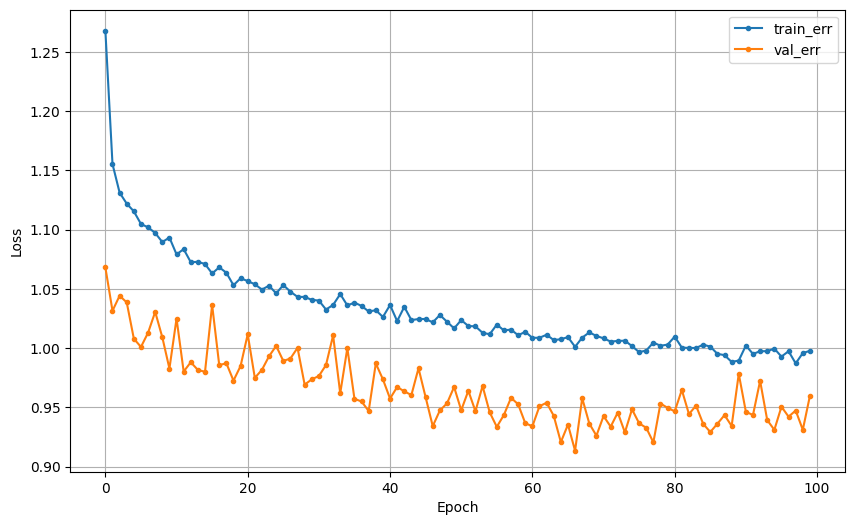

In [17]:
# 학습결과 그래프
dl_history_plot(history)

In [18]:
pred = model.predict(x_val)
# softmax는 결과들 중에서 가장 유력한 것을 선택해야 함
pred = pred.argmax(axis=1) # target범주들 중에서 가장 유력한 것을 선택

print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[ 16  27  18   0   0]
 [ 17 212 203   5   1]
 [  3 120 482  55   0]
 [  0   4 180  66   0]
 [  0   0  39  21   1]]
              precision    recall  f1-score   support

           0       0.44      0.26      0.33        61
           1       0.58      0.48      0.53       438
           2       0.52      0.73      0.61       660
           3       0.45      0.26      0.33       250
           4       0.50      0.02      0.03        61

    accuracy                           0.53      1470
   macro avg       0.50      0.35      0.37      1470
weighted avg       0.52      0.53      0.50      1470



### (3) 모델3

- 50 > 25 > 10 > 5 로 구성해보자



In [21]:
# 메모리 정리
clear_session()

# 모델 생성
model = Sequential(
    [Input(shape = (n,)),
     Dense(50,activation='relu'),
     Dense(25,activation='relu'),
     Dense(10,activation='relu'),
     Dense(5,activation='softmax') # 다중분류에서 output layer는 softmax 이다 ,
     # 그리고 target 범주 수 만큼 output
     ]
)

# 모델요약
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │              55 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,190 (8.55 KB)

 Trainable params: 2,190 (8.55 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# 0,1,2 정수 인코디시 loss function은 sparse_categorical_crossentropy 사용한다
model.compile(optimizer=Adam(learning_rate=0.01), loss= 'sparse_categorical_crossentropy')

# 0,1,2,3 정수 라벨링인 경우 loss function 은 sparse_categorical_crossentropy
history = model.fit(x_train, y_train, epochs = 100,validation_split=0.2, verbose= False).history

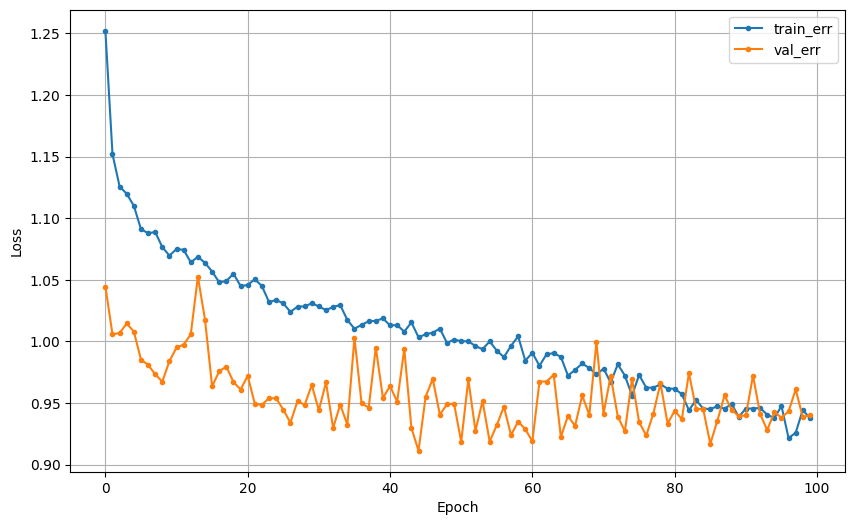

In [23]:
# 학습결과 그래프
dl_history_plot(history)

In [24]:
# 예측 + 평가
pred = model.predict(x_val)
# softmax는 결과들 중에서 가장 유력한 것을 선택해야 함
pred = pred.argmax(axis=1) # target범주들 중에서 가장 유력한 것을 선택

print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[  8  35  18   0   0]
 [  9 278 145   5   1]
 [  2 150 434  74   0]
 [  0   7 158  79   6]
 [  0   0  27  32   2]]
              precision    recall  f1-score   support

           0       0.42      0.13      0.20        61
           1       0.59      0.63      0.61       438
           2       0.55      0.66      0.60       660
           3       0.42      0.32      0.36       250
           4       0.22      0.03      0.06        61

    accuracy                           0.54      1470
   macro avg       0.44      0.35      0.37      1470
weighted avg       0.52      0.54      0.52      1470

